# Molecular simulation of Hydrogen molecule (H2)

Any molecular simulation with classical or Quantum computer involves the following key steps which we automate at some level.

- First Quantization
- calculating the integrals in the first quantization
- Second Quantization
- Simulation using Hartree Fock
- Mapping to Pauli spins
- Prepapre ansatz
- Create the circuit by applying the hamiltonian
- Perform VQE by optimizing the parameters in each step

This notebook will walk you through the steps one by one also explain the code

In [ ]:
# Mandatory Packages installations

#pip install pyscf
#pip install qiskit
#pip install qiskit_ibm_runtime

### Heavy Reading Alert!!!

The gto package in PySCF provides tools for defining molecules, including their atomic geometries, basis sets, and nuclear information. It facilitates setting up the quantum chemistry calculations by handling the molecular structure, atomic orbitals, and integral computations needed for further quantum simulations.

The above code intializes a water molecule ($H_2 O$). with Oxygen atom at (0,0,0) position and the two Hydrogens placed at (0,1,0) -> Y-axis and (0,0,1) -> Z-axis, with bond distance (or Bond length) = 1.
The "atom" parameter is to specify the goemetry of the molecule

basis parameter has information about the basis set (or basis functions) used to map the probability distribution of the electrons in the molecule.

gto -> means Gaussian Type Orbitals 

STO-3G is a minimal basis set using 3 Gaussian functions to approximate each Slater-type orbital. STO are basis functions that resemble the exact solutions for hydrogen-like atoms

Molecular orbitals are expressed as linear combinations of basis functions (GTOs or STOs):
$\Psi(r) = \sum_i c_i \phi_i(r)$

$\Psi(\mathbf{r})$: Molecular orbital. 

$c_i$: Coefficients determined by solving the Schrödinger equation.

$\phi_i(\mathbf{r})$: Basis functions (GTOs or STOs).


Electrons play a pivotal role in determining the chemical and physical properties of atoms and molecules. Their distribution around nuclei dictates how atoms bond, how molecules interact, and ultimately, the behavior of materials and biological systems. The Schrödinger equation, which governs the behavior of electrons, cannot be solved exactly for multi-electron systems (i.e., atoms beyond hydrogen and molecules). Therefore, approximations are necessary. This is where basis sets, composed of orbitals like GTOs and STOs, come into play.

**Slater Type Orbitals** are mathematical functions that closely resemble the true solutions of the Schrödinger equation for hydrogen-like atoms. The general form of an STO is:

$
\phi_{\text{STO}}(r, \theta, \phi) = N r^{n-1} e^{-\zeta r} Y_l^m(\theta, \phi)
$

- $  r, \theta, \phi $: Spherical coordinates.
- $  \zeta $: Effective nuclear charge.
- $  Y_l^m $: Spherical harmonics representing angular parts.
- $  N $: Normalization constant.
- $  n, l, m $: Quantum numbers representing principal, angular momentum, and magnetic quantum numbers, respectively.

First step in the process of simulating molecules as mentioned above is first quantization. In simple words it is writing up the Hamiltonian, adding all the energy terms in the system. The energy of nuclues, electron, couloumb interactions between them, and electron electron interactions. As they change with spacetime, they are calculated using the Integrals.

The Hamiltonian looks something like this for Hydrogen like atoms.

$
\hat{H} = \sum_i T_i + \sum_{i,A} V_{iA} + \sum_{i<j} \frac{1}{|\mathbf{r}_i - \mathbf{r}_j|}
$

1.Overlap Integrals ($S_{ij}$): The overlap integral measures how much two basis functions $\phi_i$ and $\phi_j$ overlap with each other in space. It is given by:

- $S_{ij} = \int \phi_i(\mathbf{r}) \phi_j(\mathbf{r}) \, d\mathbf{r}$


- In constructing molecular orbitals, these integrals tell us how linearly dependent or orthogonal the basis functions are. The closer two orbitals are spatially, the larger their overlap integral.


2.Kinetic Energy Integrals ($T_{ij}$): The kinetic energy integral represents the kinetic energy of the electrons, and it is expressed as:

- $T_{ij} = -\frac{1}{2} \int \phi_i(\mathbf{r}) \nabla^2 \phi_j(\mathbf{r}) \, d\mathbf{r}$

- It represents the expectation value of the kinetic energy operator acting on the electron's wavefunction. This term accounts for the motion of electrons and their contribution to the total energy of the system.


3.Nuclear Attraction Integrals ($V_{ij}$): The nuclear attraction integral describes the attraction between electrons and nuclei. It is given by:

- $V_{ij} = -\sum_A Z_A \int \frac{\phi_i(\mathbf{r}) \phi_j(\mathbf{r})}{|\mathbf{r} - \mathbf{R}_A|} \, d\mathbf{r}$
where $Z_A$ is the charge of nucleus $A$ and $\mathbf{R}_A$ is the position of nucleus $A$.

- It accounts for the attractive force between the negatively charged electrons and the positively charged nuclei. It represents how much the electron's wavefunction is "pulled" towards the nucleus.


4.Two-Electron Integrals ($\langle ij | kl \rangle$): The two-electron integral describes the repulsion between two electrons located in different molecular orbitals. It is given by:

$
\langle ij | kl \rangle = \iint \frac{\phi_i(\mathbf{r}_1) \phi_j(\mathbf{r}_1) \phi_k(\mathbf{r}_2) \phi_l(\mathbf{r}_2)}{|\mathbf{r}_1 - \mathbf{r}_2|} \, d\mathbf{r}_1 \, d\mathbf{r}_2
$

- This integral represents the Coulombic repulsion between electrons in different orbitals. It tells us how the electron-electron repulsion contributes to the total energy of the system.

After calculating these integrals, the energy Hamiltonian can be converted to second quantization which will be in the form of creation and annihilaiton operators with some coeffiecients calculated through the integrals.

In first quantization, the Hamiltonian is expressed in terms of the spatial coordinates of the electrons. We compute the integrals discussed above using the spatial wavefunctions (basis functions) to get the matrix elements that represent interactions like kinetic energy, electron-nucleus attraction, and electron-electron repulsion. 

In second quantization, the Hamiltonian is transformed into a formalism that uses creation ($a^\dagger a^\dagger$ ) and annihilation (a a) operators to represent the addition or removal of electrons from orbitals. This transition allows for a more convenient representation of many-body systems, where we don't need to explicitly track the position of each electron.

The Hamiltonian in second quantization is expressed in terms of the integrals over the molecular orbitals (which are linear combinations of the basis functions):

$
\hat{H} = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} g_{pqrs} a_p^\dagger a_q^\dagger a_r a_s
$

- $h_{pq}$: Represents the one-electron integrals (kinetic energy and nuclear attraction), derived from overlap, kinetic, and nuclear attraction integrals.
- $g_{pqrs}$: Represents the two-electron integrals, which come from the electron-electron repulsion.

So, in First Quantization, the wavefunctions (basis functions) are used to compute the integrals (overlap, kinetic energy, nuclear attraction, and two-electron integrals).
In second Quantization the integrals are then used to construct the Hamiltonian in terms of creation and annihilation operators.

More clear details about all these CHemistry details are in this [link](https://qiskit-community.github.io/qiskit-nature/tutorials/01_electronic_structure.html)

/Users/rishwithimmaraju/QuantumPython/.venv/lib/python3.12/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = 2.71588739329275
converged SCF energy = 0.164175012061695
converged SCF energy = -0.593827758535727
converged SCF energy = -0.90436139416354
converged SCF energy = -1.04299627454009
converged SCF energy = -1.1011282422677
converged SCF energy = -1.11734903499028
converged SCF energy = -1.11085039747659
converged SCF energy = -1.09191404102006
converged SCF energy = -1.06610864931794
converged SCF energy = -1.03653887502918
converged SCF energy = -1.00510670656849
converged SCF energy = -0.973110615777578
converged SCF energy = -0.941480654707799
converged SCF energy = -0.910873554594387
converged SCF energy = -0.881732449946057
converged SCF energy = -0.854337626951292
converged SCF energy = -0.828848147926977
converged SCF energy = -0.805332844893277
converged SCF energy = -0.783792654277353
converged SCF energy = -0.764177651616798
converged SCF energy = -0.746401349991159
converged SCF energy = -0.730353321354887
converged SCF energy = -0.715910060453806
conve

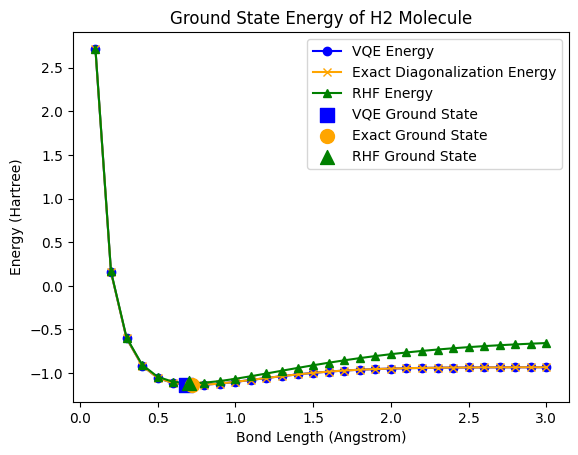

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from pyscf import gto, scf

# Define bond lengths
bond_lengths = np.linspace(0.1, 3.0, 30)

# Jordan-Wigner Mapper
mapper = JordanWignerMapper()

# Prepare to collect results
vqe_energies = []
exact_diagonalization_energies = []
rhf_energies = []

# Loop over bond lengths
for bond_length in bond_lengths:
    # Define molecule for PySCFDriver
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {bond_length}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    # Set up problem
    es_problem = driver.run()

    # Define VQE ansatz and solver
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
    
    # Set up and solve with VQE
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    vqe_result = calc.solve(es_problem)
    vqe_energies.append(vqe_result.total_energies[0])

    # Set up and solve with exact diagonalization
    from qiskit_algorithms import NumPyMinimumEigensolver
    exact_solver = NumPyMinimumEigensolver()
    calc_exact = GroundStateEigensolver(mapper, exact_solver)
    exact_result = calc_exact.solve(es_problem)
    exact_diagonalization_energies.append(exact_result.total_energies[0])

    # Solve using Restricted Hartree-Fock (RHF)
    mol = gto.M(
        atom=f'H 0 0 0; H 0 0 {bond_length}',
        basis='sto-3g',
        unit='Angstrom',
        spin=0,
        charge=0
    )
    mf = scf.RHF(mol)
    rhf_energy = mf.kernel()
    rhf_energies.append(rhf_energy)

# Find minimum energies and corresponding bond lengths for VQE and exact solver
min_vqe_energy = min(vqe_energies)
min_vqe_bond = bond_lengths[vqe_energies.index(min_vqe_energy)]

min_exact_energy = min(exact_diagonalization_energies)
min_exact_bond = bond_lengths[exact_diagonalization_energies.index(min_exact_energy)]

min_rhf_energy = min(rhf_energies)
min_rhf_bond = bond_lengths[rhf_energies.index(min_rhf_energy)]

# Print the ground state values for all methods
print(f"VQE Ground State Energy: {min_vqe_energy:.6f} Hartree at bond length {min_vqe_bond:.2f} Å")
print(f"Exact Diagonalization Ground State Energy: {min_exact_energy:.6f} Hartree at bond length {min_exact_bond:.2f} Å")
print(f"RHF Ground State Energy: {min_rhf_energy:.6f} Hartree at bond length {min_rhf_bond:.2f} Å")

# Plot results
plt.plot(bond_lengths, vqe_energies, label="VQE Energy", marker='o', color='blue')
plt.plot(bond_lengths, exact_diagonalization_energies, label="Exact Diagonalization Energy", marker='x', color='orange')
plt.plot(bond_lengths, rhf_energies, label="RHF Energy", marker='^', color='green')

# Mark the ground state energy points with offset and different shapes
plt.scatter(min_vqe_bond - 0.02, min_vqe_energy, color='blue', label='VQE Ground State', s=100, zorder=5, marker='s')  # Square for VQE, slightly offset
plt.scatter(min_exact_bond + 0.02, min_exact_energy, color='orange', label='Exact Ground State', s=100, zorder=5, marker='o')  # Circle for Exact, slightly offset
plt.scatter(min_rhf_bond, min_rhf_energy, color='green', label='RHF Ground State', s=100, zorder=5, marker='^')  # Triangle for RHF

# Labels and title
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.title("Ground State Energy of H2 Molecule")
plt.legend()
plt.show()


# Plotting the same plot bigger

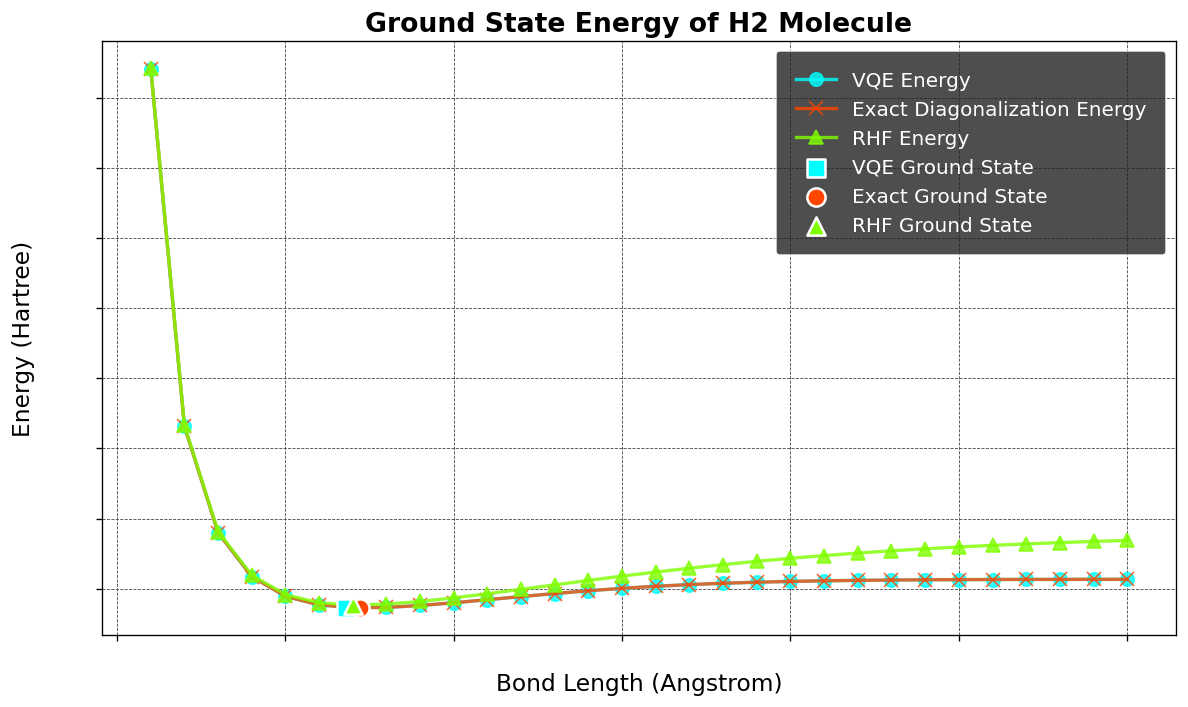

In [3]:
# Plot results with a more elegant design
plt.figure(figsize=(10, 6), dpi=120)
#plt.style.use('dark_background')

# Plot energy curves with neon colors
plt.plot(bond_lengths, vqe_energies, label="VQE Energy", marker='o', color='#00FFFF', linewidth=2, markersize=8, alpha=0.8)
plt.plot(bond_lengths, exact_diagonalization_energies, label="Exact Diagonalization Energy", marker='x', color='#FF4500', linewidth=2, markersize=8, alpha=0.8)
plt.plot(bond_lengths, rhf_energies, label="RHF Energy", marker='^', color='#7FFF00', linewidth=2, markersize=8, alpha=0.8)

# Highlight the ground state energy points with large markers
plt.scatter(min_vqe_bond - 0.02, min_vqe_energy, color='#00FFFF', label='VQE Ground State', s=120, zorder=5, marker='s', edgecolor='white', linewidth=1.5)
plt.scatter(min_exact_bond + 0.02, min_exact_energy, color='#FF4500', label='Exact Ground State', s=120, zorder=5, marker='o', edgecolor='white', linewidth=1.5)
plt.scatter(min_rhf_bond, min_rhf_energy, color='#7FFF00', label='RHF Ground State', s=120, zorder=5, marker='^', edgecolor='white', linewidth=1.5)

# Add grid and customize ticks
plt.grid(color='#444444', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Labels and title with neon glow effect
plt.xlabel("Bond Length (Angstrom)", fontsize=14, color='#000000')
plt.ylabel("Energy (Hartree)", fontsize=14, color='#000000')
plt.title("Ground State Energy of H2 Molecule", fontsize=16, color='#000000', weight='bold')

# Add legend with a sleek background
legend = plt.legend(fontsize=12, loc='best', frameon=True, facecolor='#222222', edgecolor='white', borderpad=1)
for text in legend.get_texts():
    text.set_color("white")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
